# Stroke Project

# Goals
* Discover the drivers that increase the risk factor of stroke
* Use drivers to develop a machine learning model to predict weather or not a patient has had a stroke.
* Use findings to see what preventitave measures if any can be taken to decrease the risk of stroke

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import wrangle as w
import explore as e

from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
# Decision Tree and Model Evaluation Imports
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# Acquire
* Data acquired from kaggle on 12-13-2022
    https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv
* Data contains 5110 rows and 12 columns
* Each row represents a patient and information about the patient
* Each column representa a features related to the patient

In [3]:
# acquire data from csv file
df= w.get_stroke_data()

# Prepare
prepare actions:
  * removed columns with unnecessary information
  * renamed columns and values
  * 211 null values where found and will be imputed after split
  * Outliers have not been removed
  * Encoded categorical variables
  * Split data into train, validate and test:
        (Approximately: train 56%, validate 24%, test 20%)

  * impute 211 null values under BMI column with median due to the right skewness of feature 
  
  * Continuous variables will be scaled before modeling.

In [4]:
# prepare data
df = w.data_prep(df)

In [5]:
# split data and impute bmi by mean
train, validate, test = w.split_and_impute_data(df, 'stroke')

# Data Dictionary

| Feature    | Description    | 
| :------------- | -------------: | 
|      id     |   unique identifier      | 
|   gender       |    Gender of patient Male or Female or Other     | 
| age|     age of the patient     | 
|      hypertension    |     If a patient has hypertension  (1 = yes, 0 = no)  | 
|      hear_disease     |     If a patient has any heart diseases  (1 = yes, 0 = no)  | 
|       ever_married   |   If a patient has ever been married (1 = yes, 0 = no)      | 
|    work_type       |    The work type of patient. *Children are under children category     | 
|  residence_type        |     If a patient residence is  rural of urban   | 
|   avg_glucose_level        |    average glucose level in blood     | 
|     bmi     |   body mass index of patient      | 
|   smoking_status       |    smoking status of patient * Unknown represent the information was unavailable     | 
|          |         | 

# Explore

# 1. What is the percent of patients who have a stroke?


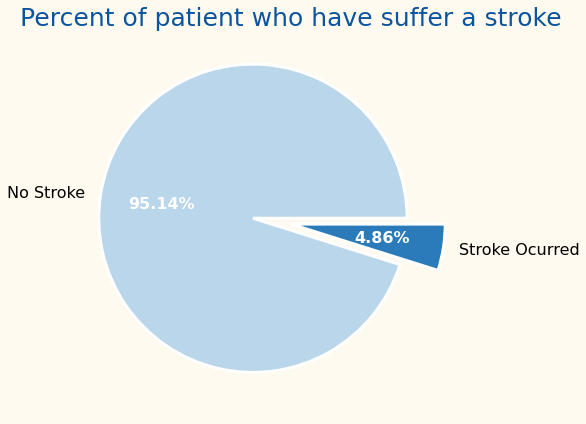

In [6]:
# obtain visualization for percent of patients who have suffer a stroke
e.viz_stroke_percentage(train)

***About 5 % of our patients have suffer a stroke***

# 2. Does the presense of hypertension increase the risk of stroke?


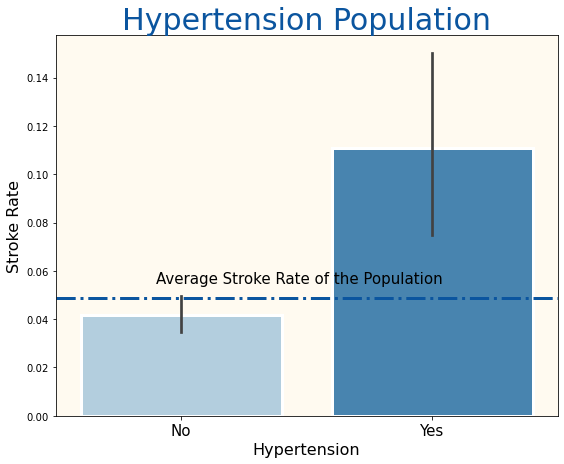

In [7]:
# obtain visualization for hypertension vs stroke
e.viz_hypertension_vs_stroke(train)

***It appears that patients with hypertension tend to have a higher stroke rate than patients without hypertension***

### I will now conduct a chi-square test to determine if there is an association between hypertension  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Hypertension is **independent**   of stroke.

$H_a$: Hypertension is **dependent** of stroke.

In [8]:
# obtain chi square test
e.chi_square_test(train,'stroke', 'hypertension')

 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07


Since the p-value is less than alpha we reject the null hypothesis. There is evidence to support that hypertention has an association with stroke. I believe that hypertention is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 3. Are patients with a heart condition more at risk of stroke than patients with hypertension?

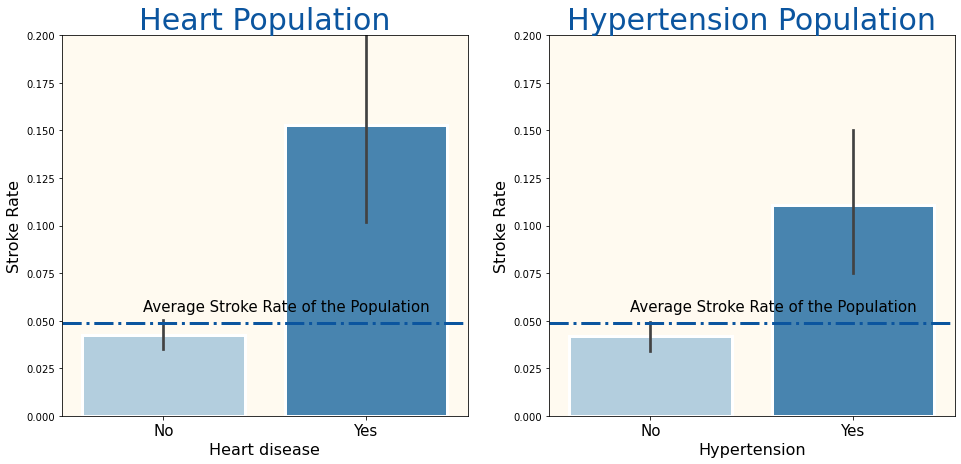

In [9]:
# obtain visualization for heart disease populatin vs stroke and hypertension population vs stroke
e. viz_heart_hyper_stroke(train)

***It appears that patients with a heart condition tend to have a higher stroke rate than patients with hypertension***

### I will now conduct a chi-square test to determine if there is an association between heart condition  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$: Patients with a heart condition is **independent**   of stroke.

$H_a$: Patients with a heart condition **dependent** of stroke.

In [10]:
# obtain chi square test
e.chi_square_test(train,'stroke', 'heart_disease')

 Chi-Square:36.73001998146243
 p-value:1.356740136221253e-09


Since the p-value is less than alpha we reject the null hypothesis. There is evidence to support that patients with heart disease has an association with stroke. I believe that heart disease is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 4. Controling for gender of a patient, does heart disease increases risk of stroke?

In [11]:
# create subgroups for male and female
male_subset = train[train.gender_Male==1]
female_subset = train[train.gender_Male==0]

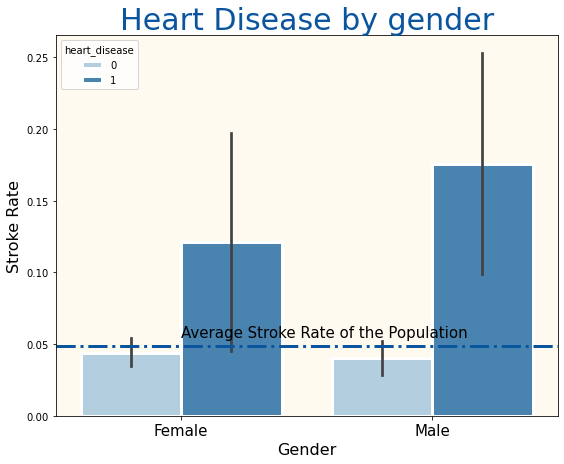

In [12]:
# obtain visualization controling for gender heart disease vs stroke
e.viz_gender_heart_stroke(train)

***It appears that males with hypertension have an above average stroke rate.
Also males with hypertensio have a higher stroke rate than females***

### I will now conduct a chi-square test  is the male population with heart disease associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Males with hypertension is **independent**   of stroke.

$H_a$: Males with hypertension is **dependent** of stroke.

In [13]:
e.chi_square_test(male_subset,'stroke', 'heart_disease')


 Chi-Square:29.08260992156263
 p-value:6.935676062013279e-08


Since the p-value is less than alpha we reject the null Hypothesis. There is evidence to support that males a heart disease has an association with stroke.  Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

### I will now conduct a chi-square test  is the female population with heart disease associated with stroke.
* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Females with hypertension is **independent**   of stroke.

$H_a$: Females with hypertension is **dependent** of stroke.

In [14]:
e.chi_square_test(female_subset,'stroke', 'heart_disease')

 Chi-Square:6.8306066361801525
 p-value:0.008960882580754448


Since the p-value is less than alpha we reject the null Hypothesis. There is evidence to support that females with a heart diseas has an association with stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 5. Is age a driver of stroke?

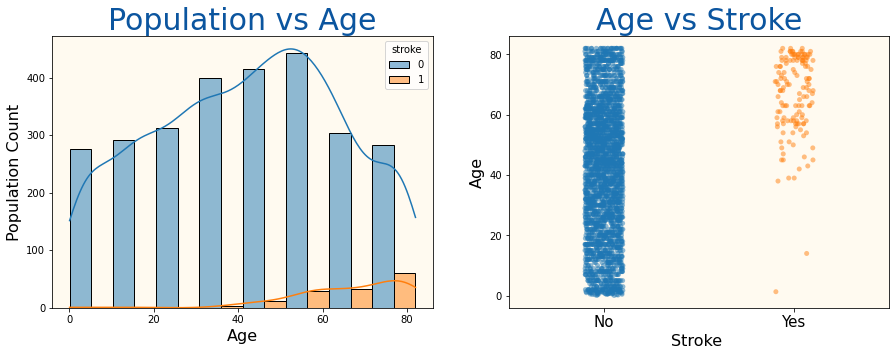

In [15]:
# obtain graph age vs stroke
e.viz_age_vs_stroke(train)

***It seems that with as our patients age increases so does the instances of occurance of a stroke.***

### I will conduct a t-test to determine if the population who has suffer a stroke has a higher mean age thatn the population who has not had a stoke occurance.
* The confidence interval is 95%
* Alpha is set to 0.05
* This will be a Independent t-test

$H_0$ : The mean age of patients who have suffer a stroke <= to the mean age of patients who have not suffer a stroke

$H_a$: The mean age of patients who have suffer a stroke > to the mean age of patients who have not suffer a stroke


In [16]:
# obtain ttest for age vs stroke
e.ttest(train,'stroke','age')

t-stat 20.108050826301564
p-value 5.1422688960466496e-48


Since the p-value/2 is less than alpha we reject the null Hypothesis. There is evidence to support that patients who suffer a stroke  on average are older than patients who have not suffer a stroke. Based on this statistical finding I believe that age is a driver of stroke. Adding an scaled version of this feature to the model will likely increase the model ability to predict home value.

# 6. Do patients who have ever been married suffer more strokes than patients that have not been married

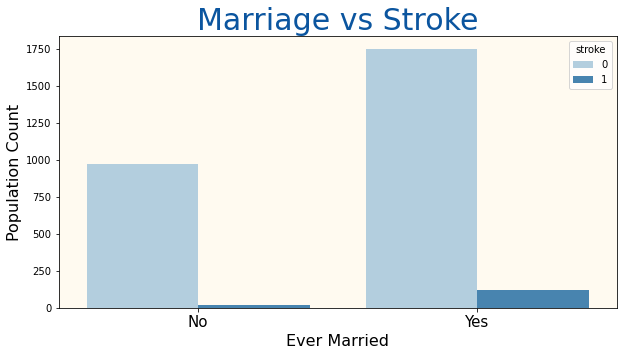

In [46]:
# visualization for patients who have been married vs stroke
viz_marriage_vs_stroke(train)

***There seems to be a slight increase in stroke for those patients who have been married.***

### I will now conduct a chi-square test  if patients who have been married is associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Patients who have been married are **independent**   of stroke.

$H_a$: Patients who have been married are not **dependent** of stroke.

In [45]:
e.chi_square_test(train, 'stroke','ever_married_Yes')

 Chi-Square:33.01784652416314
 p-value:9.131679279313294e-09


The p-value is less than alpha and we reject the null hypothesis. There is evidence to support that patients who have been married has an association with stroke. I believe that marriage is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# Exploration Summary

* 4.86% of our patient populatin has suffer a stroke
* Patients with hypertension have an increase in stroke rate
* Patients with heart disease have an increase in stroke rate
* Patients wih heart disease have a larger increase in stroke rate than patients with hypertension
* The male gender of our patients that have heart disease have a higher stroke rate than the female gender
* The patients age is a driver of stroke
* Patients who have been married have a slight increase in stroke rate.

# Features that will be included in my model:

The following features where found significant trough exploration and statistical testing and will be kept for modeling:
* hypertension 
* heart_disease
* gender_Male (encoded)
* age (scaled)
* ever_married_Yes (encoded)

Target variable: Stroke

In [54]:
# save features kept for modeling
modeling_features = ['hypertension','heart_disease','gender_Male','age','ever_married_Yes', 'stroke']

# Features that will be not included in my model:

The following features will not be used for this iteration of modeling:
* work_type
* residence_type
* avg_glucose_level
* bmi
* smoking_status


# Modeling:
*
*

In [53]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale,
               scaler=MinMaxScaler()):
    
    """
    Scales the 3 data splits. 
    Takes in train, validate, and test data 
    splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    
    Imports Needed:
    from sklearn.preprocessing import MinMaxScaler 
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import QuantileTransformer
    
    Arguments Taken:
               train = Assign the train DataFrame
            validate = Assign the validate DataFrame 
                test = Assign the test DataFrame
    columns_to_scale = Assign the Columns that you want to scale
              scaler = Assign the scaler to use MinMaxScaler(),
                                                StandardScaler(), 
                                                RobustScaler(), or 
                                                QuantileTransformer()
       return_scaler = False by default and will not return scaler data
                       True will return the scaler data before displaying the _scaled data
    """
    
    # make copies of our original data so we dont corrupt original split
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    # fit the scaled data
    scaler.fit(train[columns_to_scale])
    
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled

In [56]:
def model_prep(train,validate,test, modeling_features):
    
    ''' 
    model_prep takes in train, validate, test and features used for modeling,
    scales continuous variable
    removes features not used for modeling and 
    sepertes the target variable into its own dataframe
    returns x_train,y_train,x_validate,y_validate, x_test, y_test
        
    '''
    #scale continuous variables:
    scale_data(train, 
               validate, 
               test, 
               ['age',
               scaler=MinMaxScaler())
    
    # drop unused columns and keep some features
    features = features
    train =train[features]
    validate = validate[features]
    test = test[features]
        
    #seperate target
    x_train = train.drop(columns=['stroke'])
    y_train = train.stroke

    x_validate = validate.drop(columns=['stroke'])
    y_validate = validate.stroke

    x_test = test.drop(columns=['stroke'])
    y_test = test.stroke
        
    # Convert binary categorical target variable to numeric
    return x_train,y_train,x_validate,y_validate, x_test, y_test

In [58]:
x_train,y_train,x_validate,y_validate, x_test, y_test= model_prep(train,validate,test,modeling_features)

ValueError: Expected 2D array, got 1D array instead:
array=[ 2. 49. 47. ... 56. 82. 46.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
stat_features = ['age','avg_glucose_level','hypertension','heart_disease','ever_married_Yes',
'work_type_Self-employed','smoking_status_formely_smoked', 'smoking_status_unknown','stroke']

In [ ]:
X_train,y_train,X_validate,y_validate, X_test, y_test = model_prep(train,validate,test,stat_features)

In [ ]:
y_validate.shape,X_validate.shape,X_train.shape,y_train.shape,X_test.shape, y_test.shape

In [ ]:
train.shape

In [ ]:
train.stroke.value_counts()

In [ ]:
2649/ 2788

In [ ]:
# baseline is 95% accuracy
baseline = y_train.mode()
baseline

X_train['baseline_prediction'] = int(baseline)
X_train


In [ ]:
#Loop for models
for i in range(1, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i,min_samples_split = 5, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
y_validate.shape,X_validate.shape,X_train.shape,y_train.shape

In [ ]:

metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    

    
    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    # calculate recall train
    y_pred = tree.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  
      
    # calculate recall validate
    y_pred = tree.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df

In [ ]:
df.sort_values(by=['recall_difference', 'train_recall'])

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o', label = 'Train')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o', label = 'Validate')


#plt.plot(df_2.max_depth, df_2.validate_accuracy, marker = 'x', label = 'Validate')

plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Random forest changing leaf

for i in range(1, 21):
  
    # Make the model
    random_forest = RandomForestClassifier(max_depth=10, min_samples_leaf = i , random_state=123)

    # Fit the model (on train and only train)
    random_forest = random_forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_pred = random_forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_pred, output_dict=True)
    print(f"Tree with min sample leaf {i}")
    print(pd.DataFrame(report))
    print()
    
    
    # create data frame
        # calculate recall train
    y_pred = random_forest.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)
    
    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = random_forest.score(X_train, y_train)
    
    
    
    out_of_sample_accuracy = random_forest.score(X_validate, y_validate)

    
      
    # calculate recall validate
    y_pred = random_forest.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
 

In [ ]:
# Random forest changing max-depth and leaf
metrics =[]
for h in range(10,0,-1):
    print(f'max depth {h}')
    for i in range(1, 21):
  
        # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)

        # Fit the model (on train and only train)
        random_forest = random_forest.fit(X_train, y_train)

        # Use the model
        # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(X_train)
        # calculate recall validate

        in_sample_recall= recall_score(y_train, y_pred)     

        # Produce the classification report on the actual y values and this model's predicted y values
        report = classification_report(y_train, y_pred, output_dict=True)
        print(f"Tree with min sample leaf {i}")
        print(f'max depth {h}')
        print(pd.DataFrame(report))
        print()
        
        
        # calculate recall validate
        y_pred = random_forest.predict(X_validate)
        out_of_sample_recall= recall_score(y_validate, y_pred)
        
        # Produce the classification report on the actual y values and this model's predicted y values
        report = classification_report(y_validate, y_pred, output_dict=True)
        print(f"Tree with min sample leaf {i}")
        print(f'max depth {h}')
        print(pd.DataFrame(report))
        print()
        
        output = {
            "max_depth": h,
            'leaf_min':i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            'train_recall': in_sample_recall,
            'validate_recall': out_of_sample_recall
        }

        metrics.append(output)

df2 = pd.DataFrame(metrics)
df2["accuracy_difference"] = df2.train_accuracy - df2.validate_accuracy
df2["recall_difference"] = df2.train_recall - df2.validate_recall


In [ ]:
df2

In [ ]:

metrics=[]
for h in range(10,0,-1):
   
    print(f'max depth {h}')
    
    for i in range(1, 21):
  
    # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)
    
    # Fit the model (on train and only train)
        random_forest.fit(X_train, y_train)
        
         # Use the model
    # We'll evaluate the model's performance on train, first
        in_sample_accuracy = random_forest.score(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(X_train)
        
        output = {
        "max_depth": h,
        "min_samples_leaf": i,
        "train_accuracy": in_sample_accuracy,
        #"validate_accuracy": y_pred
    }

        metrics.append(output)
        
        df = pd.DataFrame(metrics)
df
  

In [ ]:
df.sort_values(by='train_accuracy')

# KNN

In [ ]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.3f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
metrics=[]
for i in range(1,21):
    # weights = ['uniform', 'density']
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    

    in_sample_accuracy =knn.score(X_train, y_train)

    out_sample_accuracy =knn.score(X_validate, y_validate)

    # calculate recall train
    y_pred = knn.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  

    # calculate recall validate
    y_pred = knn.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)

    output = {
        "neighbor": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
  

In [ ]:
df.sort_values(by='validate_recall',ascending=False)

In [ ]:
metrics=[]
for i in range(1,21):
    # weights = ['uniform', 'density']
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)

    in_sample_accuracy =knn.score(X_train, y_train)
     
    # calculate recall train
    y_pred = knn.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  

    # calculate recall validate
    y_pred = knn.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)

    output = {
        "neighbor": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
  

# Logistic regression

In [ ]:
metrics=[]
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1)
logit.fit(X_train, y_train)

in_sample_accuracy =logit.score(X_train, y_train)
out_sample_accuracy=logit.score(X_validate, y_validate)

# calculate recall train
y_pred = logit.predict(X_train)
in_sample_recall= recall_score(y_train, y_pred)  

# calculate recall validate
y_pred = logit.predict(X_validate)
out_of_sample_recall= recall_score(y_validate, y_pred)

output = {
 
    "train_accuracy": in_sample_accuracy,
    "validate_accuracy": out_of_sample_accuracy,
    'train_recall': in_sample_recall,
    'validate_recall': out_of_sample_recall
}

metrics.append(output)

df2 = pd.DataFrame(metrics)
df2["accuracy_difference"] = df2.train_accuracy - df2.validate_accuracy
df2["recall_difference"] = df2.train_recall - df2.validate_recall
df2
